In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from geopy.distance import geodesic
import warnings
from matplotlib.ticker import MaxNLocator
import datetime
from dateutil.relativedelta import relativedelta
import sys, copy, os, shutil
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# create a directory for preliminary figures
if "figures" not in os.listdir():
    os.mkdir("figures")
if "eda" not in os.listdir("figures"):
    os.mkdir("figures/eda")

# Top 30 largest counties by population in the Northeastern United States.

In [2]:
# states that we will shortlist for consideration in our analyses
northeastern_states = ["Connecticut", "District of Columbia", "Delaware", 
                       "Massachusetts", "Maryland", "Maine", "New Hampshire", "New Jersey", "New York",
                       "Pennsylvania", "Rhode Island", "Virginia", "Vermont"]

# load our index files, limit to Northeastern United States
index = pd.read_csv("raw/index.csv").query(f"country_name == 'United States of America'")
index = index[index.subregion1_name.isin(northeastern_states)]
index = index.query("aggregation_level == 2").drop(columns=["place_id", "wikidata_id", "datacommons_id", 
                                                            "country_code", "country_name", "locality_code", 
                                                            "locality_name", "iso_3166_1_alpha_2", 
                                                            "iso_3166_1_alpha_3"])
index = index.reset_index(drop=True)

# load in our population data for these Northeastern United States locations
demog = pd.read_csv("raw/demographics.csv").set_index("location_key")
demog = demog.loc[index.location_key][["population"]].reset_index()

# stitch together index with demog
index = pd.concat([index, demog], axis=1).sort_values(by="population", ascending=False)

# let's finalize our locations of interest + rename our columns
locations = index.head(30).sort_values(by="subregion1_name")
locations.rename(inplace=True, columns={"subregion1_code" : "state_code", "subregion1_name" : "state_name",
                                        "subregion2_code" : "zip_code", "subregion2_name" : "county_name"})
locations = locations.loc[:,~locations.columns.duplicated()].copy()

# let's record the geographical latitude + longitude of our locations, too.
geography = pd.read_csv("raw/geography.csv")
geography = geography.loc[geography.location_key.isin(locations.location_key)]\
[["location_key", "latitude", "longitude"]]

# get our locations updated
locations = pd.concat([locations.set_index("location_key"), 
                       geography.set_index("location_key")], axis=1).reset_index()

# save as a processed file!
locations.sort_values(by="location_key", inplace=True)
locations.reset_index(inplace=True, drop=True)
locations.to_csv("processed/locations.csv", index=False)

# Extracting case counts for these 30 counties.

In [3]:
# load our epidemiological files
epidem = pd.read_csv("raw/epidemiology.csv")
epidem = epidem.loc[epidem["location_key"].isin(locations.location_key)]\
.reset_index(drop=True)[["date", "location_key", "new_confirmed"]]

# creating an overall dataframe with nothing in it right now
all_cases = pd.DataFrame(data=None)

# go thru each of our chosen locations!
for location_key in locations.location_key:
    
    # get the cases for this location
    cases = epidem.query(f"location_key == '{location_key}'").drop(columns=["location_key"])
    cases.date = pd.to_datetime(cases.date)
    cases.set_index("date", inplace=True)
    cases.rename(columns={"new_confirmed" : location_key}, inplace=True)
    
    # add to our all_cases
    all_cases = pd.concat([all_cases, cases], axis=1)

# drop all the dates that we have NaN's for -- so we have a contiguous block!
all_cases.dropna(inplace=True)
all_cases = all_cases.applymap(lambda x: max(0, x))

# save our file as daily
all_cases.to_csv("processed/daily_cases.csv", index=True)

# get our weekly cases (aggregated)
all_cases_weekly = all_cases.reset_index().resample("W", on="date").sum()
all_cases_weekly.to_csv("processed/weekly_cases.csv", index=True)

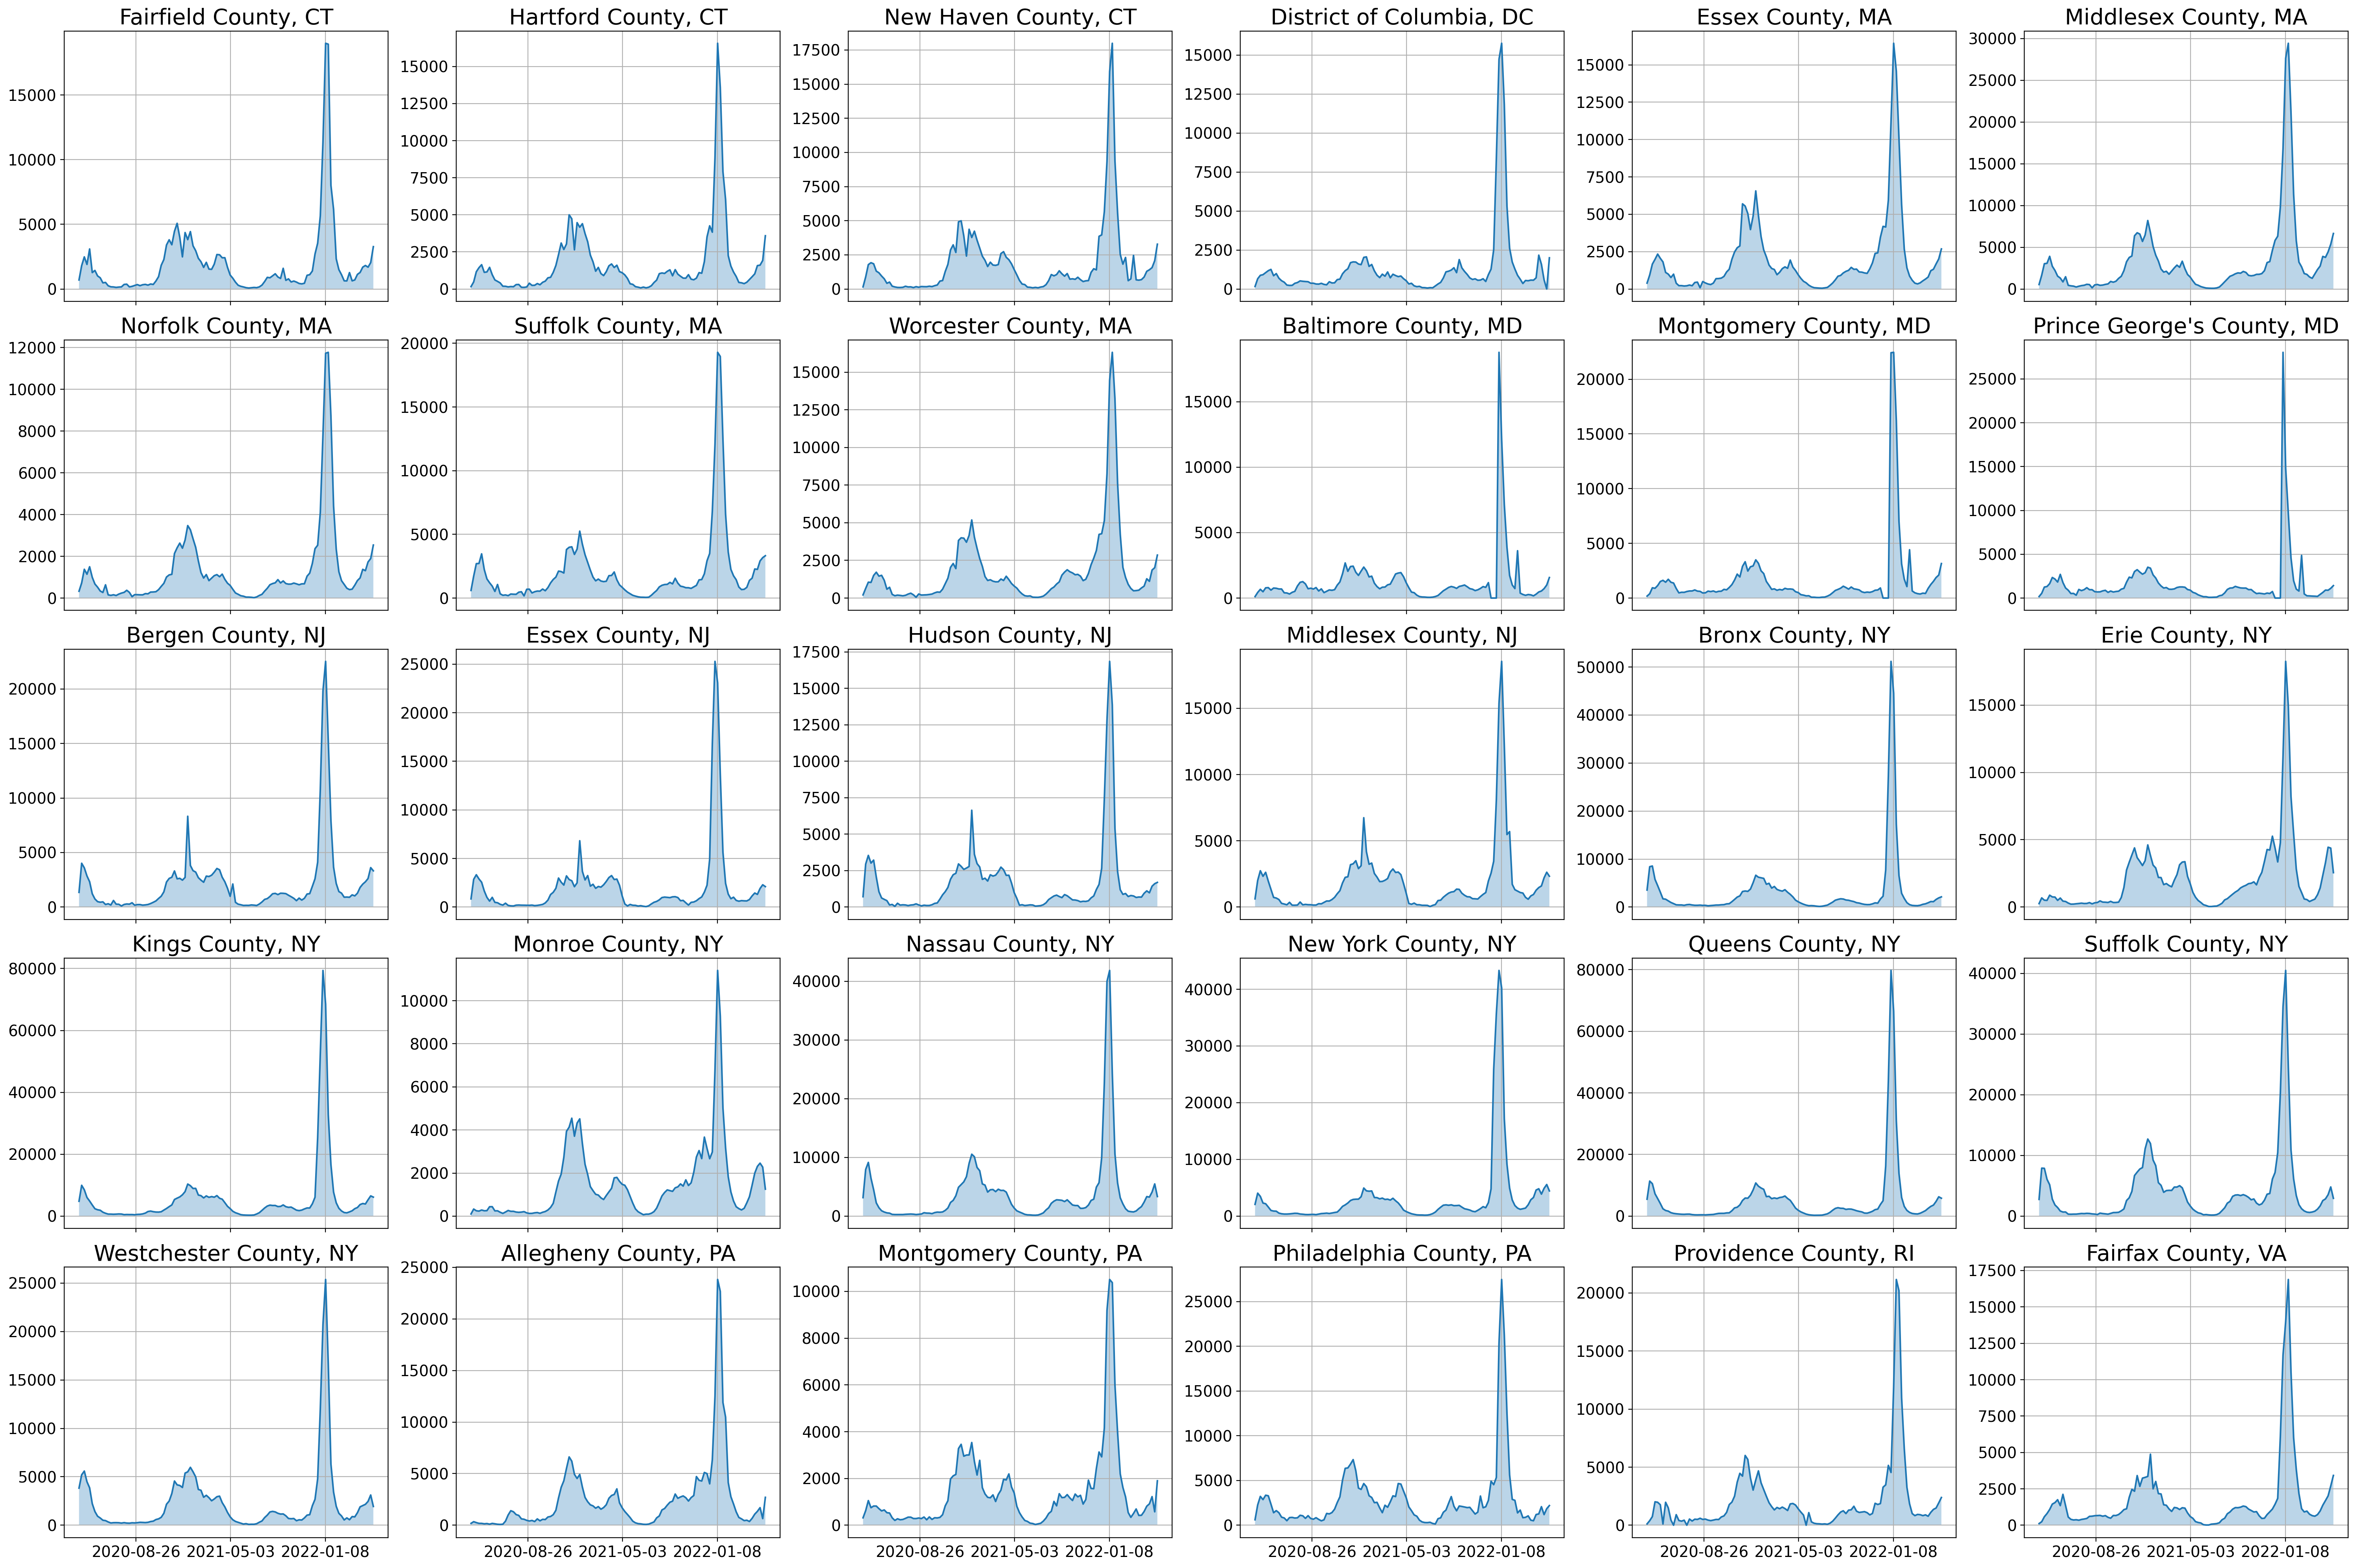

In [4]:
# EDA on our data - let's see what weekly case counts look like in our 30 locations
fig, ax = plt.subplots(5, 6, dpi=200, figsize=(30, 20), sharex=True)

# iterate through all of our locations
for i, location_key in enumerate(all_cases_weekly.columns):
    
    # plot the case counts
    ax[i // 6, i % 6].plot(all_cases_weekly[location_key])
    ax[i // 6, i % 6].fill_between(all_cases_weekly[location_key].index,
                                   all_cases_weekly[location_key].values, alpha=0.3)
    ax[i // 6, i % 6].grid()
    
    # get the county name + state
    county_name = locations.query(f"location_key == '{location_key}'").county_name.values[0]
    state = locations.query(f"location_key == '{location_key}'").state_code.values[0]
    ax[i // 6, i % 6].set_title(f"{county_name}, {state}", fontsize=20)
    ax[i // 6, i % 6].xaxis.set_major_locator(MaxNLocator(4))
    ax[i // 6, i % 6].tick_params("both", labelsize=14)
    
# beautify at the very end
plt.tight_layout()
plt.savefig("figures/eda/all_weekly_cases.png", bbox_inches="tight", facecolor="white")
plt.show()

# Visualizing the geographical spread of our counties.

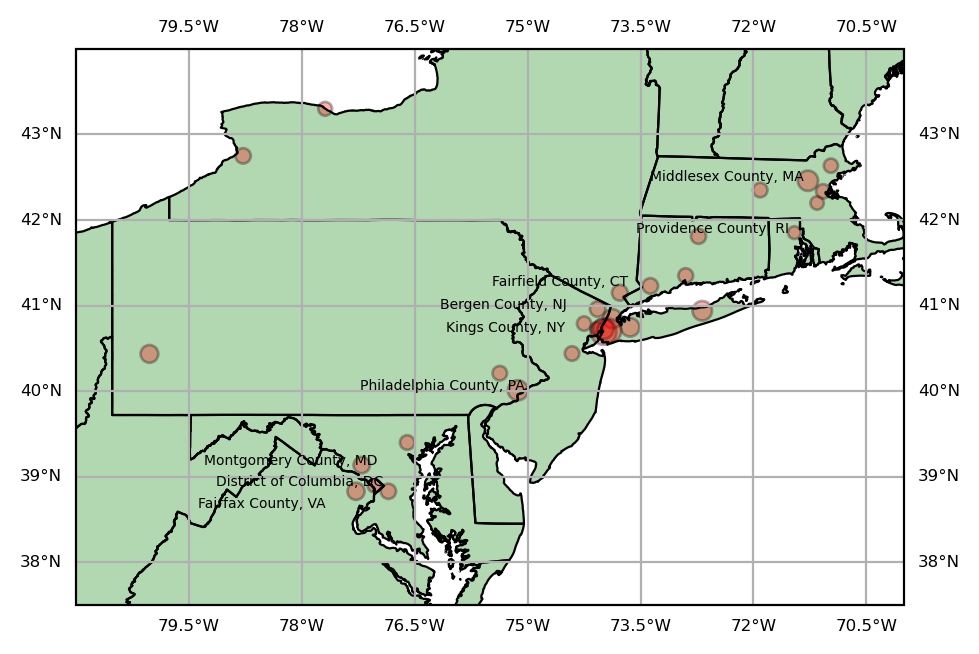

In [5]:
# suppress warnings for now
warnings.filterwarnings("ignore")

# Load US states from US Census Bureau
# src: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
us_states = gpd.read_file("raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

# create our figure + restrict it to the Northeastern United States
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(5, 4), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
us_states.plot(ax=ax, linewidth=0.8, color="green", alpha=0.3)
us_states.boundary.plot(ax=ax, linewidth=0.8, color="black")
ax.set_extent([-81, -70, 44, 37.5])
lines = ax.gridlines(draw_labels=True, xlabel_style = {'size': 6}, ylabel_style = {'size': 6})

# let's scatter plot all of our locations
ax.scatter(locations.longitude, locations.latitude, 
           s=locations.population / 30000, 
           edgecolor="black", facecolor="red", alpha=0.3)

# sort our locations + get the biggest counties in each state
sorted_locations = locations.sort_values(by="population", ascending=False)\
.groupby("state_code").first().reset_index()
for i in range(9):
    
    lon, lat, county_name, state_code = sorted_locations.loc[i][["longitude", "latitude",
                                                                 "county_name", "state_code"]]
    offset = -0.2 if county_name == "Fairfax County" else 0
    ax.annotate(text=f"{county_name}, {state_code}", xy=(lon-2.1, lat + offset), 
                fontsize=5, color="black")
    
# beautify
plt.tight_layout()
plt.savefig("figures/map.png", facecolor="white", bbox_inches="tight")
plt.show()

# Clustering for GCNN Experimental Setups

## Clustering Method 1: Political Clustering

In [6]:
# CLUSTERING / EDGE INDEX METHOD 1: KEEP STATES DISCONNECTED (but DC + MD + Virginia), (RI with MA)
if "political_clustering" not in os.listdir("processed"):
    os.mkdir("processed/political_clustering")

# make a copy of our locations dataframe to keep things clean
pol_locations = copy.deepcopy(locations) # alphabetical will be our de facto ordering

# make our modifications for DC + MD + Virginia, RI + MA
pol_locations["state_code"] = pol_locations["state_code"]\
.replace(to_replace="DC", value="MD")\
.replace(to_replace="VA", value="MD")\
.replace(to_replace="RI", value="MA")

# save our .csv first
pol_locations.to_csv("processed/political_clustering/political_locations.csv", index=False)

# create a list of edge connections, also an adjacency matrix
edge_indices1, adj_matrix1 = [], np.zeros((len(pol_locations.index), len(pol_locations.index)))

# start encoding our edge connections
for i in range(len(pol_locations.index)):
    for j in range(len(pol_locations.index)):
        
        # check if these two locations are in the same code
        if pol_locations.loc[i].state_code == pol_locations.loc[j].state_code:
            
            # add to our edge indices + encode this in our adjacency matrix
            edge_indices1.append([i, j])
            adj_matrix1[i, j] = 1.0
            
# format into a way that PyTorch likes (we can keep as np.arrays for saving)
edge_indices1 = np.array(edge_indices1).T
np.savetxt(fname="processed/political_clustering/edge_indices1.txt", X=edge_indices1)
np.savetxt(fname="processed/political_clustering/adj_matrix1.txt", X=adj_matrix1)

# how many clusters did we end up having
num_clusters1 = len(pol_locations.state_code.unique())
print(f"Political clustering outputs {num_clusters1} clusters.")

Political clustering outputs 6 clusters.


## Clustering Method 2

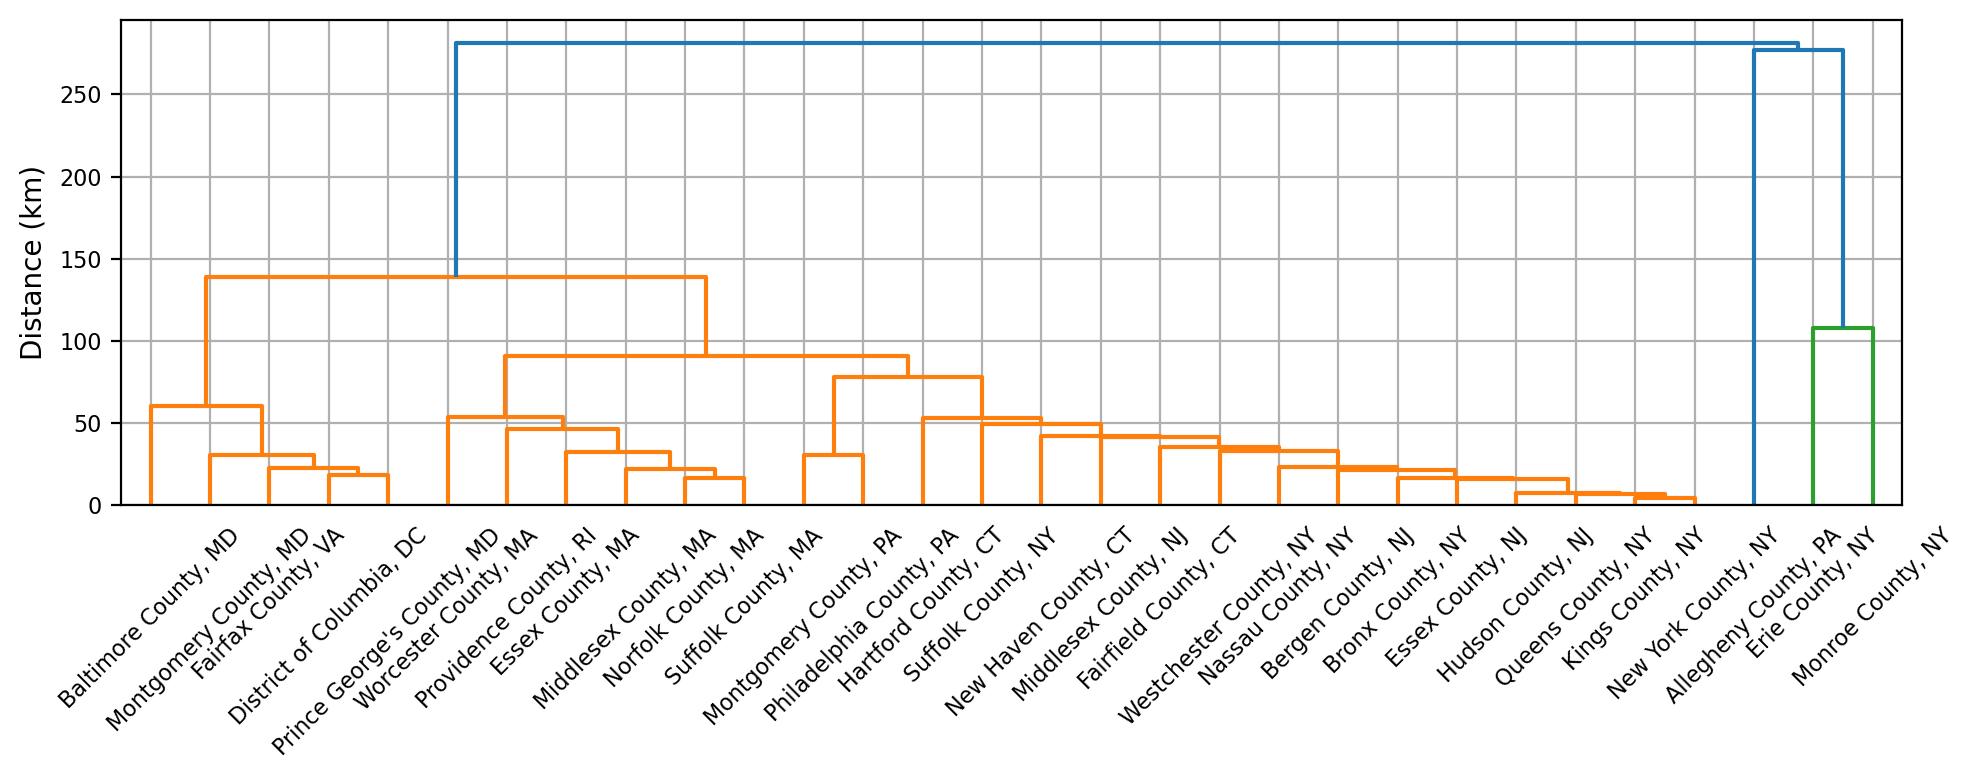

In [7]:
# CLUSTERING / EDGE INDEX METHOD 2: Hierarchical Agglomerative Clustering by Distance
if "distance_clustering" not in os.listdir("processed"):
    os.mkdir("processed/distance_clustering")

# encode our distance function between (lat, lon) coordinates!
def dist(x1, x2):
    return geodesic(x1, x2).kilometers

# let's do HAC using the min of clusters to connect two clusters
Z = sch.linkage(y=locations[["latitude", "longitude"]].values, method="single", metric=dist)

# get our clean labels
labels = [f"{locations.county_name[i]}, {locations.state_code[i]}" for i in range(len(locations.index))]

# plot our dendrogram
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(10, 4))
ax.grid()
dend = sch.dendrogram(Z, labels=labels, ax=ax)
ax.tick_params("both", labelsize=8)
ax.set_ylabel("Distance (km)")
plt.tight_layout()
plt.savefig("figures/eda/distance_tree.png", facecolor="white", bbox_inches="tight")
plt.show()

In [8]:
# start our lists of clusters, encoded from our HAC dendrogram
clusters2 = [[3, 9, 10, 11, 29], # DMV
             [4, 5, 6, 7, 8, 28], # New England
             [26, 27], # Pennsylvania 2x
             [0, 1, 2, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24], # Greater New York Area
             [17, 19, 25], # Pittsburgh and Co.
            ]

# create a list of edge connections, also an adjacency matrix
edge_indices2, adj_matrix2 = [], np.zeros((len(locations.index), len(locations.index)))

# keep a list of the biggest county in each cluster
biggest_counties = []

# start iterating thru each cluster and encoding these edge connections first
for cluster in clusters2:
    
    # encode connections between counties in each cluster
    for i in range(len(cluster)):
        for j in range(len(cluster)):
            
            # increment both edge connections and adjacency matrix entries!
            edge_indices2.append([cluster[i], cluster[j]])
            adj_matrix2[cluster[i], cluster[j]] = 1.0
    
    # what's the biggest county in this cluster?
    biggest_county = locations.loc[cluster].population.idxmax()
    biggest_counties.append(biggest_county)
    
# finally, encode connections between the biggest counties (flight, hubs, etc.)
for i in range(len(biggest_counties)):
    for j in range(len(biggest_counties)):
        
        # increment our edge connections and adjacency matrix entries
        edge_indices2.append([biggest_counties[i], biggest_counties[j]])
        adj_matrix2[biggest_counties[i], biggest_counties[j]] = 1.0
        
# format into a way that PyTorch likes (we can keep as np.arrays for saving)
edge_indices2 = np.array(edge_indices2).T
np.savetxt(fname="processed/distance_clustering/edge_indices2.txt", X=edge_indices2)
np.savetxt(fname="processed/distance_clustering/adj_matrix2.txt", X=adj_matrix2)

# how many clusters did we end up having
num_clusters2 = len(clusters2)
print(f"Distance clustering outputs {num_clusters2} clusters.")

Distance clustering outputs 5 clusters.


## Clustering Method 3

In [9]:
# CLUSTERING / EDGE INDEX METHOD 1: KEEP STATES DISCONNECTED (but DC + MD + Virginia), (RI with MA)
if "single_clustering" not in os.listdir("processed"):
    os.mkdir("processed/single_clustering")

# create a list of edge connections, also an adjacency matrix
edge_indices3, adj_matrix3 = [], np.zeros((len(locations.index), len(locations.index)))

# start encoding our edge connections
for i in range(len(locations.index)):
    for j in range(len(locations.index)):
        
        # always encode an edge connection!
        edge_indices3.append([i, j])
        adj_matrix3[i, j] = 1.0

# format into a way that PyTorch likes (we can keep as np.arrays for saving)
edge_indices3 = np.array(edge_indices3).T
np.savetxt(fname="processed/single_clustering/edge_indices3.txt", X=edge_indices3)
np.savetxt(fname="processed/single_clustering/adj_matrix3.txt", X=adj_matrix3)

# how many clusters did we end up having
print(f"Single clustering outputs 1 cluster.")

Single clustering outputs 1 cluster.


# Visualizing Clustering Approaches Via Adjacency Matrices

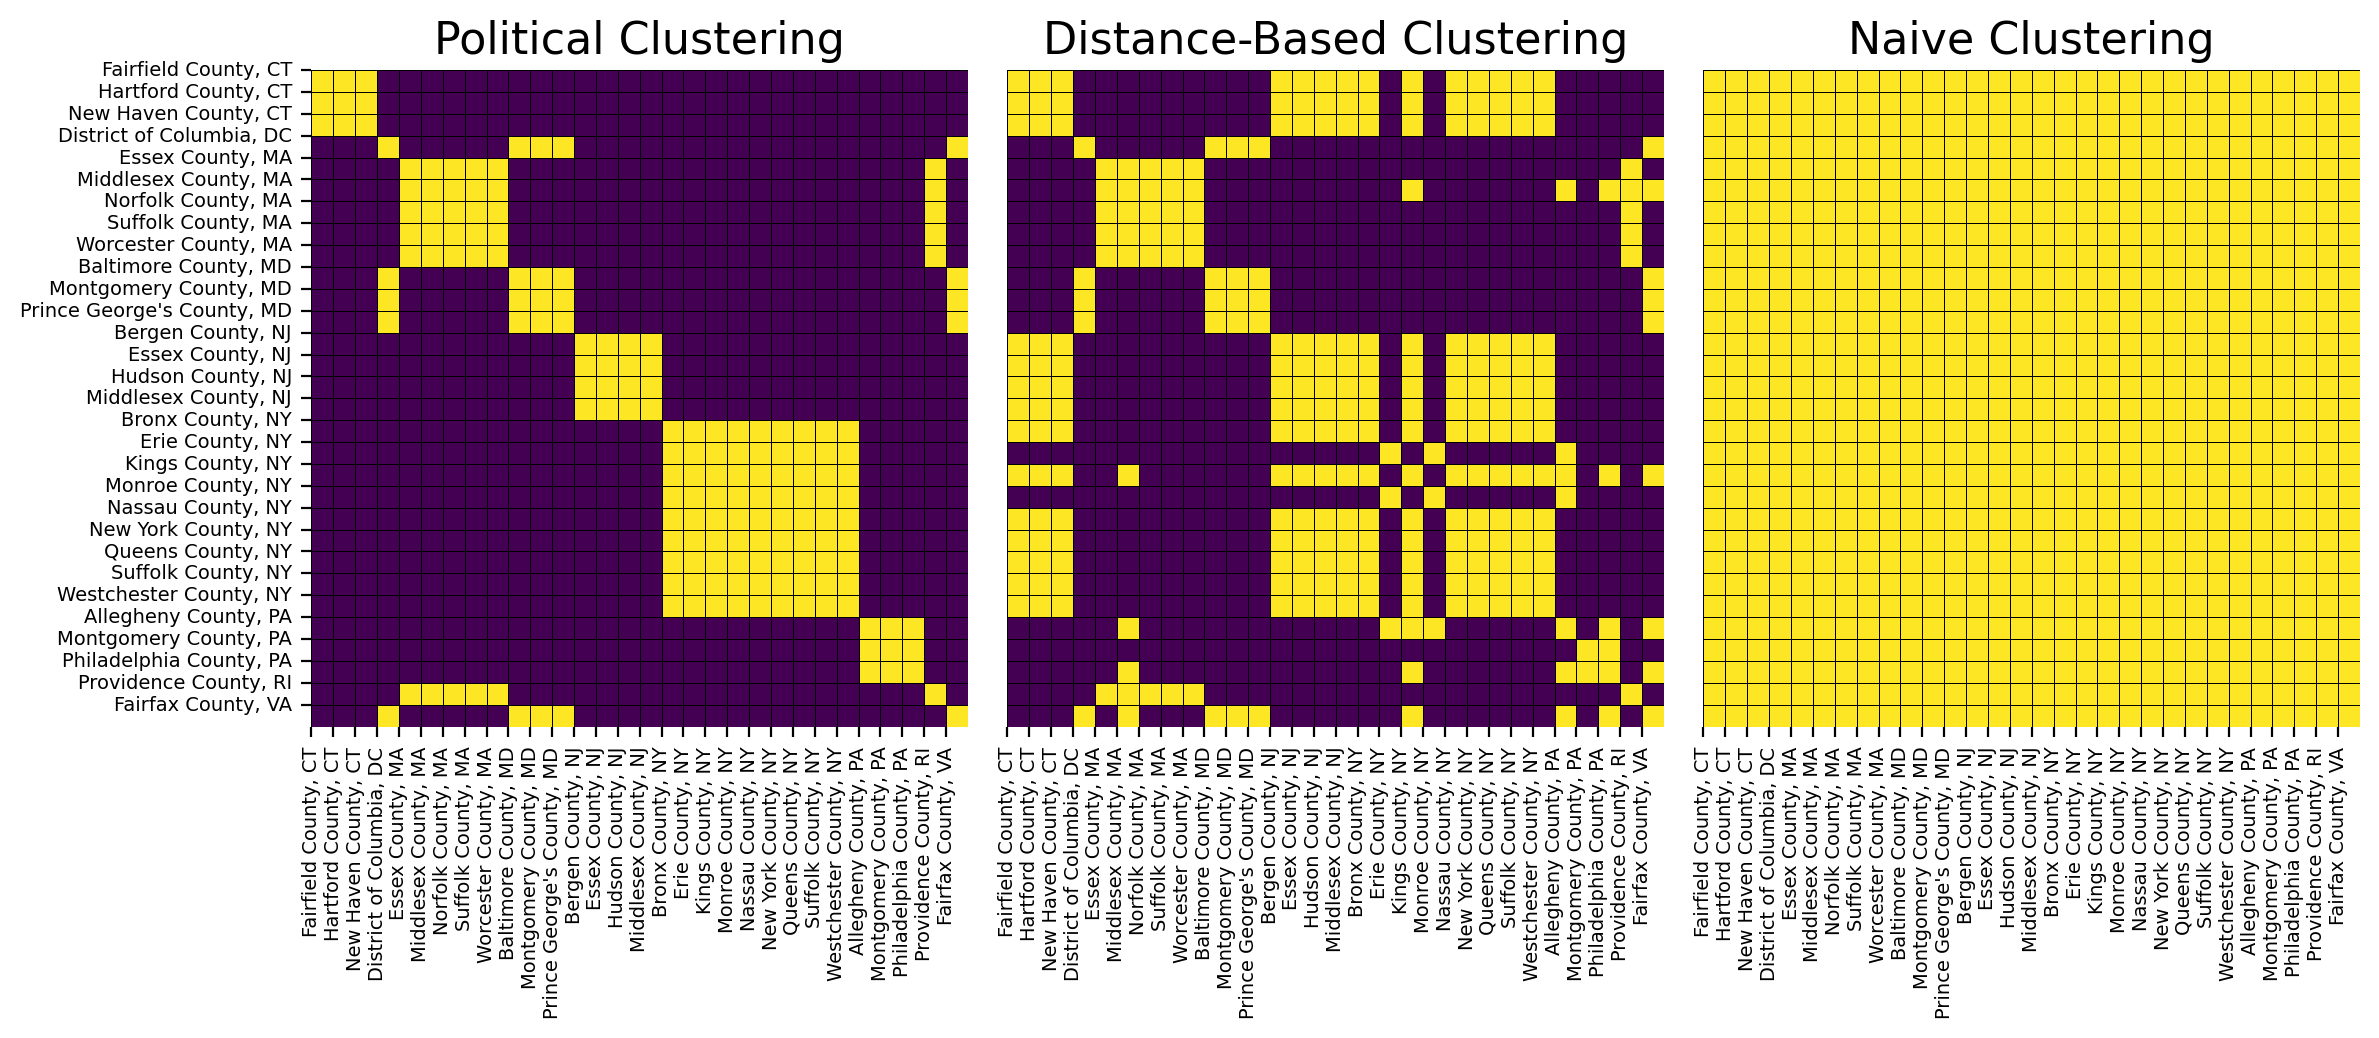

In [10]:
# create a 1x3 grid of subplots
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 6), sharey=False)

# show the disconnected political clustering
sns.heatmap(adj_matrix1, cmap="viridis", cbar=False, ax=ax[0], square=True,
            linewidths=0.25, linecolor="black", vmin=0, vmax=1)
ax[0].set_title("Political Clustering", fontsize=16)
ax[0].set_xticks(np.arange(30))
ax[0].set_xticklabels(labels, rotation=90, fontsize=7)
ax[0].set_yticks(np.arange(30))
ax[0].set_yticklabels(labels, rotation=0, fontsize=7)

# show the connected location based clustering
sns.heatmap(adj_matrix2, cmap="viridis", cbar=False, ax=ax[1], square=True,
            linewidths=0.25, linecolor="black", vmin=0, vmax=1)
ax[1].set_title("Distance-Based Clustering", fontsize=16)
ax[1].set_xticks(np.arange(30))
ax[1].set_xticklabels(labels, rotation=90, fontsize=7)
ax[1].set_yticks([])

# show the naive fully connected clustering
sns.heatmap(adj_matrix3, cmap="viridis", cbar=False, ax=ax[2], square=True,
            linewidths=0.25, linecolor="black", vmin=0, vmax=1)
ax[2].set_title("Naive Clustering", fontsize=16)
ax[2].set_xticks(np.arange(30))
ax[2].set_xticklabels(labels, rotation=90, fontsize=7)
ax[2].set_yticks([])

# beautify
plt.tight_layout()
plt.savefig("figures/eda/clustering_matrices.png", facecolor="white", bbox_inches="tight")
plt.show()

# Determining a Decent Train-Test Split

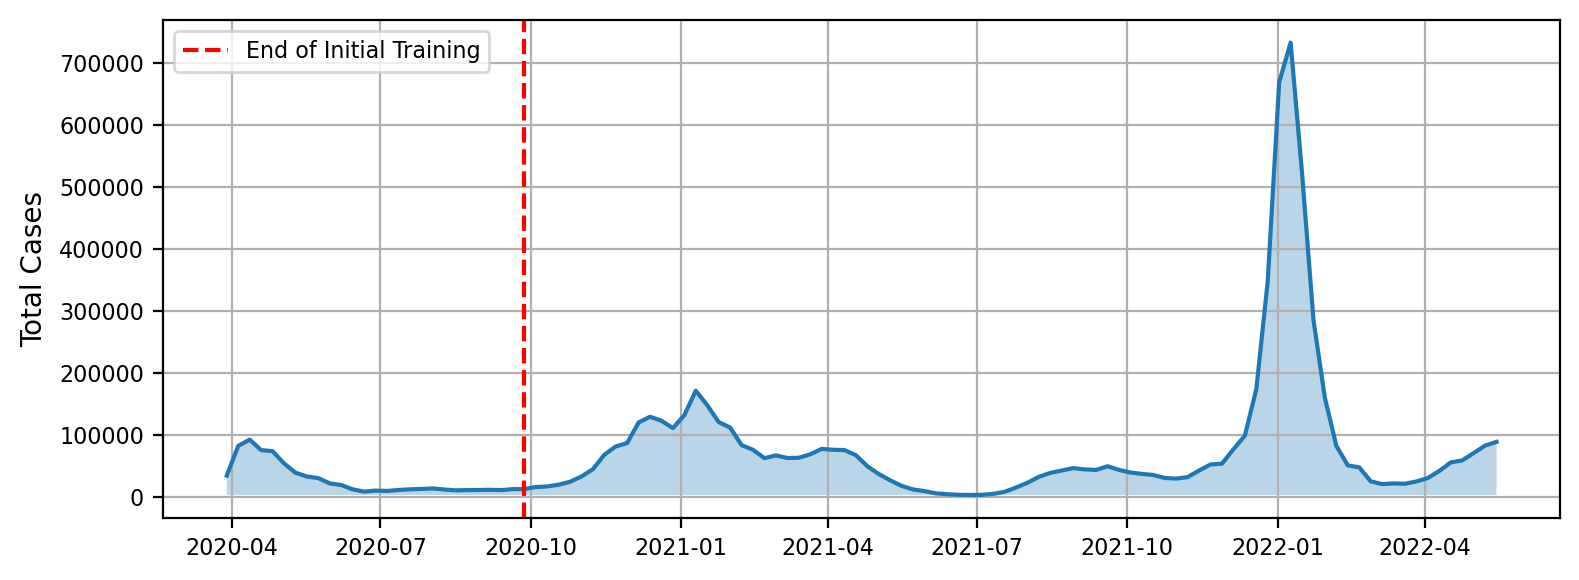

In [66]:
# look at our total counts across all locations
total_weekly = all_cases_weekly.sum(axis=1)

# make our figure
fig, ax = plt.subplots(dpi=200, figsize=(8, 3))
ax.grid()

# plot our cases
ax.plot(total_weekly)
ax.fill_between(total_weekly.index, 
                total_weekly.min(), 
                total_weekly.values, alpha=0.3)

# let's do like 6 months of training
train_start, train_end = pd.Timestamp(2020, 3, 29), pd.Timestamp(2020, 9, 27)
test_start, test_end = pd.Timestamp(2020, 10, 4), pd.Timestamp(2022, 5, 15)

# mark our dates + beautify
ax.axvline(x=train_end, linestyle="--", color="red", label="End of Initial Training")
ax.legend(loc="upper left", fontsize=8)
ax.tick_params("both", labelsize=8)

# beautify at the end
ax.set_ylabel("Total Cases")
plt.tight_layout()
plt.savefig("figures/eda/total_cases.png", facecolor="white", bbox_inches="tight")
plt.show()